# Goal: Predict the department-wide sales for each store.

## https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


## <font color='red'> Data import </font>

In [2]:
train_df = pd.read_csv("train.csv")
print(train_df.shape)

(421570, 5)


In [3]:
feature_df = pd.read_csv("features.csv")
print(feature_df.shape)

(8190, 12)


In [4]:
store_df = pd.read_csv("stores.csv")
print(store_df.shape)
store_df.head()

(45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## <font color='red'> Data Prep </font>
### Creating Month column

In [5]:
train_df['Year'] = train_df['Date'].str[0:4].astype('int32')
feature_df['Year'] = feature_df['Date'].str[0:4].astype('int32')
train_df['Month'] = train_df['Date'].str[5:7].astype('int32')
feature_df['Month'] = feature_df['Date'].str[5:7].astype('int32')
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month
0,1,1,2010-02-05,24924.50,False,2010,2
1,1,1,2010-02-12,46039.49,True,2010,2
2,1,1,2010-02-19,41595.55,False,2010,2
3,1,1,2010-02-26,19403.54,False,2010,2
4,1,1,2010-03-05,21827.90,False,2010,3


In [6]:
feature_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2010,2
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2010,2
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2010,2
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,2010,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,2013,6
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,2013,7
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,2013,7
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,2013,7


### Converting Date to Python Date type

In [7]:
train_df['Date'] =  pd.to_datetime(train_df['Date'],infer_datetime_format=True)
feature_df['Date'] =  pd.to_datetime(feature_df['Date'],infer_datetime_format=True)


### Encoding Type of Stores

In [8]:
lst = []
for idx, row in store_df.iterrows():
    if row['Type'] == "A":
        lst.append(1)
    elif row['Type'] == "B":
        lst.append(2)
    else:
        lst.append(3)
store_df['Type_Id'] = lst
store_df.head()

,Store,Type,Size,Type_Id
0,1,A,151315,1
1,2,A,202307,1
2,3,B,37392,2
3,4,A,205863,1
4,5,B,34875,2


### Merge all dataframes and create allData_df
#### *** The size resulted data frame decreased because train_df only has data until 2012 while feature_df has data until 2013 which made the resulted data frame only contains data until 2012. 

In [9]:
# find avg weekly sales for each date of each store
gb_train_df = train_df[['Store', 'Date', 'Weekly_Sales']].groupby(['Store', 'Date']).mean()
# merge it with feature df
allData_df = feature_df.merge(gb_train_df, on=['Store', 'Date'])
# merge it with store_df
allData_df = allData_df.merge(store_df[['Store', 'Size', 'Type_Id']], on='Store')
allData_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Weekly_Sales,Size,Type_Id
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,22516.313699,151315,1
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2010,2,22804.964444,151315,1
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2010,2,22081.755753,151315,1
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2010,2,19579.549861,151315,1
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,2010,3,21298.721644,151315,1


## <font color='red'> Data Exploration </font>
### <font color='blue'> 1) Does average weekly sales of each store correspond to its store size?</font>

Text(0.5, 1.0, 'Avg Weekly Sales by Store ID')

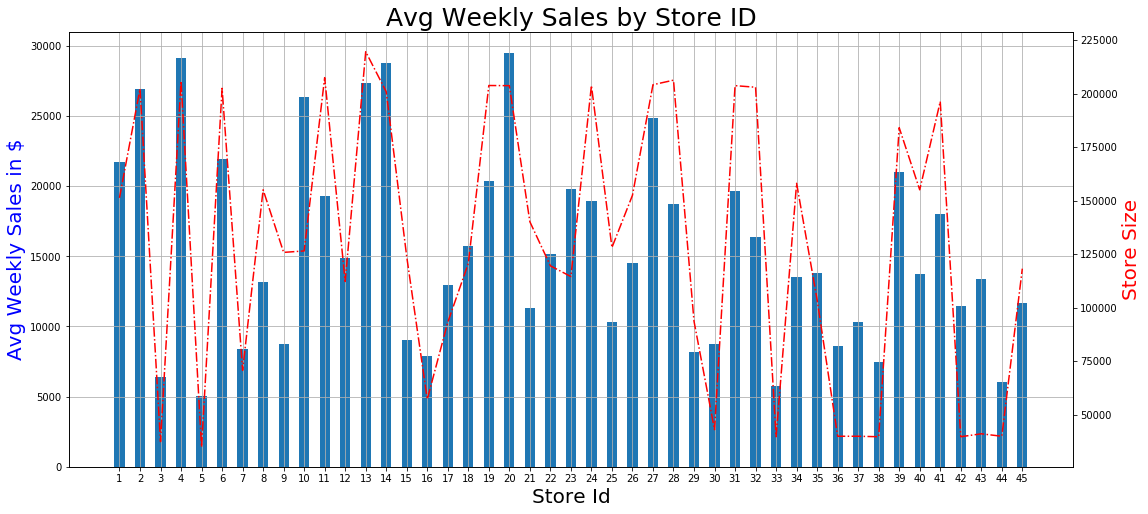

In [10]:
mean_sales_df = train_df[['Store', 'Weekly_Sales']].groupby('Store').mean()

fig, ax1 = plt.subplots(figsize = (18, 8))
ax2 = ax1.twinx() # shared x axis with ax1
ax1.bar(mean_sales_df.index, mean_sales_df['Weekly_Sales'], width=0.5)
ax2.plot(mean_sales_df.index, store_df['Size'], 'r-.')

ax1.set_xticks(mean_sales_df.index)
ax1.grid()
ax1.set_xlabel("Store Id", fontsize=20)
ax1.set_ylabel("Avg Weekly Sales in $", fontsize=20, color='b')
ax2.set_ylabel("Store Size", fontsize=20, color="r")
ax1.set_title("Avg Weekly Sales by Store ID", fontsize=25)


### Store 20 has the highest average weekly sales, followed by store 4 and store 14. Although average weekly sales of each stores corresond to its store size, some does not show direct correlationship between store size and average weekly sales. 

### <font color='blue'> 2) Analyze sales data of Christmas week and see the sales trend. Use store 13~15 for simplicity sake. </font>

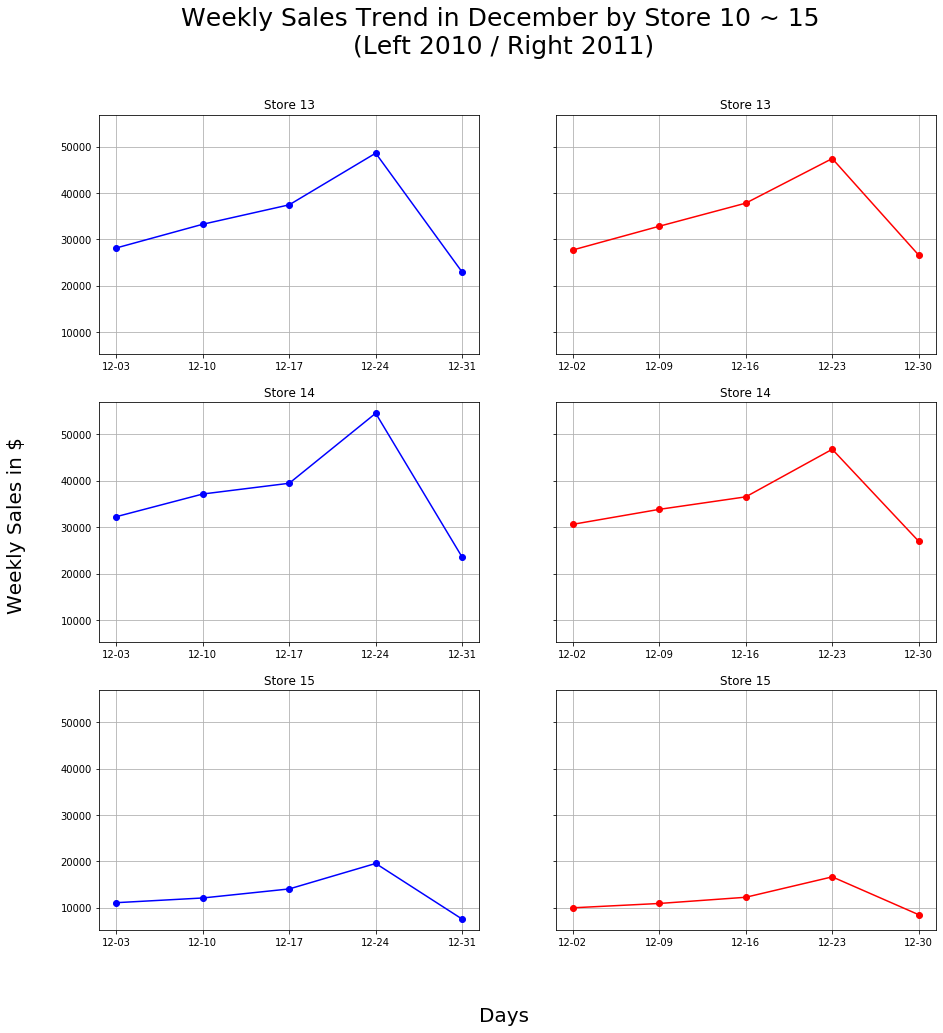

In [11]:
dec_sale_df = train_df.loc[ (train_df['Month'] == 12) & (train_df['Store'].isin(range(13,16)))][['Store', 'Date', 'Weekly_Sales', 'Year']]

fig, axs = plt.subplots(3, 2, figsize=(15,15), sharey=True)
fig.suptitle('Weekly Sales Trend in December by Store 10 ~ 15 \n(Left 2010 / Right 2011)', fontsize=25)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Weekly Sales in $', va='center', rotation='vertical', fontsize=20)
for i in range(13,16):
    df = dec_sale_df[(dec_sale_df['Store'] == i) & (dec_sale_df['Year'] == 2010)].groupby('Date').mean()
    xlabel = [str(x)[5:10] for x in df.index]
    axs[i-13, 0].plot(xlabel, df['Weekly_Sales'], 'bo-')
    axs[i-13, 0].grid()
    axs[i-13, 0].set_title(f'Store {i}')
    axs[i-13, 0].set_xticklabels(xlabel)
    df = dec_sale_df[(dec_sale_df['Store'] == i) & (dec_sale_df['Year'] == 2011)].groupby('Date').mean()
    xlabel = [str(x)[5:10] for x in df.index]
    axs[i-13, 1].plot(xlabel, df['Weekly_Sales'], 'ro-')
    axs[i-13, 1].grid()
    axs[i-13, 1].set_title(f'Store {i}')
    axs[i-13, 1].set_xticklabels(xlabel)

### From the above graph, we can notice that the overall weekly sales decrease in 2011. We can also see that weekly sales continues to increase until Christmas Eve and drops after Christmas.

### <font color='blue'> 3) Store Sizes</font>

Top 5 biggest store: 
[13 11 28  4 27]


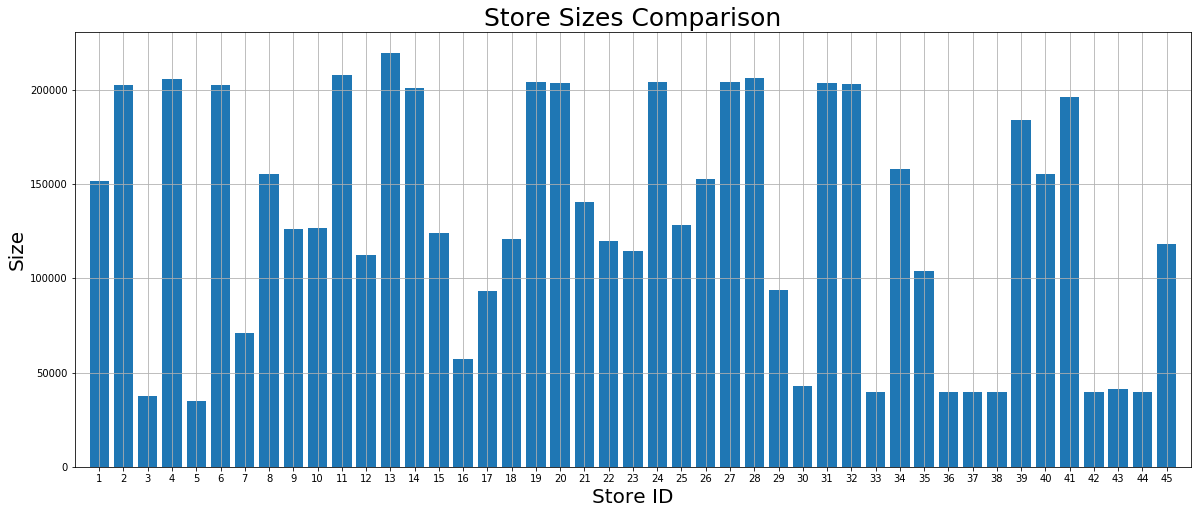

In [13]:
store_sizes = store_df.sort_values(by='Size', ascending=False)
print("Top 5 biggest store: \n{}".format(store_sizes['Store'].head().values))
plt.figure(figsize=(20,8))
plt.bar(store_sizes['Store'], store_sizes['Size'])
plt.xticks(store_sizes['Store'])
plt.xlabel("Store ID", fontsize=20)
plt.ylabel("Size", fontsize=20)
plt.title("Store Sizes Comparison", fontsize=25)
plt.xlim(0,46)
plt.grid()

#### Looks like Store 13 is the biggest store, followed by 11, 28, 4, and 27.

### <font color='blue'> 4) Which Promotional MarkDown is the highest?</font>

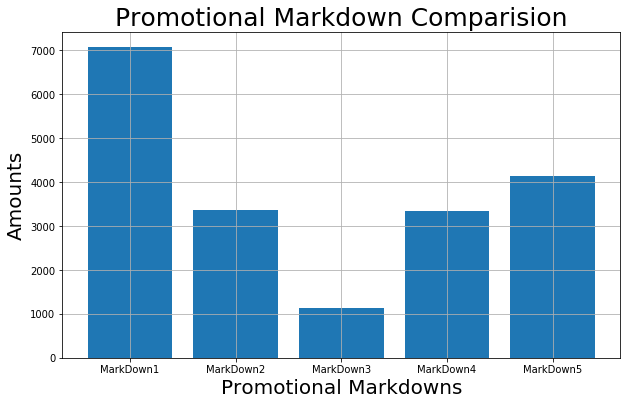

In [14]:
# Data description says:
#"MarkDown data is only available after Nov 2011, and is not available for all stores all the time"
after_dec11_df = feature_df.loc[feature_df['Date'] > '2011-12']
markdown_comparison = after_dec11_df.iloc[:, 4:9].mean()
plt.figure(figsize=(10,6))
plt.bar(markdown_comparison.index, markdown_comparison.values)
plt.title("Promotional Markdown Comparision", fontsize=25)
plt.xlabel("Promotional Markdowns", fontsize=20)
plt.ylabel("Amounts", fontsize=20)
plt.grid()

## <font color='red'> Predictive Modeling </font>
### <font color='blue'> 1) Build a predictive model that predicts the store type. </font>

### Logistic Regression

In [61]:
# Exclude MArkdowns and convert Date to int for Logistic Regression
logit_df = allData_df.drop(['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1)
logit_df['Date'] = logit_df['Date'].apply(lambda x: x.toordinal())

X_train = logit_df.iloc[:, 0:11]
y_train = logit_df['Type_Id']
# 'lbfgs' solver outputs highest accuracy.
logit_model = LogisticRegression(multi_class='multinomial',solver ='lbfgs').fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
#check 
print("Intercept: {}".format(logit_model.intercept_))
print("Intercept: {}".format(logit_model.coef_))

Intercept: [-5.20646160e-10  1.41589165e-08 -1.36382703e-08]
Intercept: [[ 9.29850808e-03 -1.17891208e-05  8.10546640e-03 -8.78061951e-05
   1.28763250e-02 -3.46375299e-04 -1.61633309e-07  3.45426433e-07
  -6.07565156e-06 -2.72039904e-04  1.36156364e-04]
 [-2.04360283e-02 -2.47255475e-06 -4.95890479e-03  2.20378717e-05
   1.10873646e-02 -4.50713062e-04  4.75411742e-06 -2.78265999e-06
   4.46554981e-05 -3.01912495e-04  1.01399095e-04]
 [ 1.11375202e-02  1.42616762e-05 -3.14656161e-03  6.57683234e-05
  -2.39636895e-02  7.97088361e-04 -4.59248411e-06  2.43723355e-06
  -3.85798465e-05  5.73952399e-04 -2.37555460e-04]]


In [63]:
y_hat = logit_model.predict(X_train)

In [64]:
logit_model.score(X_train, y_train)

0.8940170940170941

In [65]:
confusion_matrix(y_train, y_hat)

array([[2852,   94,  200],
       [ 240, 2181,   10],
       [   0,  138,  720]])

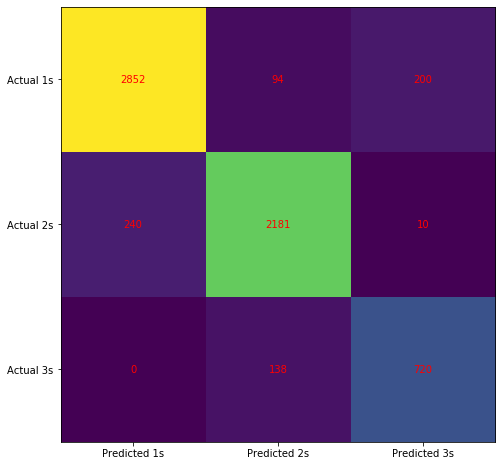

In [66]:
cm = confusion_matrix(y_train, y_hat)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(range(0,3)), ticklabels=('Predicted 1s', 'Predicted 2s', 'Predicted 3s'))
ax.yaxis.set(ticks=(range(0,3)), ticklabels=('Actual 1s', 'Actual 2s', 'Actual 3s'))

for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')


#### Results:
<ul><h3>1</h3>
    <li>Precision of 1 = (True Positive of 1) /  (Predicted Condition Positive) = (2852) / (2852+240+0) = <b>0.9223</b></li>
    <li>Sensitivity of 1 = (True Positive of 1) /  (Actual Condition Positive) = (2852) / (2852+94+200) = <b>0.9065</b></li>
    <li>Specificity of 1 = (True Negative of 1) /  (Actual Condition Negative) = (2181+10+138+720) / (2181+10+138+720+94+200) = <b>0.9121</b></li>
</ul>
<ul><h3>2</h3>
        <li>Precision of 2 = (True Positive of 2) /  (Predicted Condition Positive) = (2181) / (2181+94+138) = <b>0.9038</b></li>
    <li>Sensitivity of 2 = (True Positive of 2) /  (Actual Condition Positive) = (2181) / (2181+240+10) = <b>0.8972</b></li>
    <li>Specificity of 2 = (True Negative of 2) /  (Actual Condition Negative) = (2852+200+720+0) / (2852+200+720+0+94+138) = <b>0.9421</b></li>
</ul>
<ul><h3>3</h3>
    <li>Precision of 3 = (True Positive of 3) /  (Predicted Condition Positive) = (720) / (720+10+200) = <b>0.7742</b></li>
    <li>Sensitivity of 3 = (True Positive of 3) /  (Actual Condition Positive) = (720) / (720+138+0) = <b>0.8392</b></li>
    <li>Specificity of 3 = (True Negative of 3) /  (Actual Condition Negative) = (2852+94+2181+240) / (2852+94+2181+240+200+10) = <b>0.9623</b></li>
</ul>